In [1]:
import os
# import keras
# Using Theano Backend
#os.environ['KERAS_BACKEND']='theano'
import h5py
from keras.models import Model
from keras.layers import Input, Activation, Concatenate
from keras.layers import Flatten, Dropout
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.utils import np_utils
from keras import regularizers, optimizers
from keras.optimizers import SGD
import matplotlib
import matplotlib.pyplot as plt
import random
#import cv2
from sklearn.preprocessing import LabelEncoder
from skimage import io, transform
from sklearn.metrics import accuracy_score
from scipy import misc
import numpy as np

Using TensorFlow backend.


In [2]:
def loadData(IMAGE_SIZE):
    images = os.listdir(DATA_DIR)
    d = {} 
    data_all=[]
    train_data = []
    train_pics=[]
    train_labels = []
    test_data=[]
    test_pics=[]
    test_labels=[]
    for idx, dir in enumerate(os.listdir(DATA_DIR)):
            d[idx] = dir
            label = idx
            subdir = os.path.join(DATA_DIR, dir)
            for i, file in enumerate(os.listdir(subdir)):
                #pic = cv2.imread(os.path.join(subdir, file))
                
                pic = misc.imread(os.path.join(subdir, file))
                pic = misc.imresize(pic, (IMAGE_SIZE,IMAGE_SIZE, 3))
                data_all.append((pic, label))
    np.random.shuffle(data_all)
    validation_size = int(len(data_all) * 0.40)
    #validation_data = data_all[:validation_size].copy()
    test_size = int(validation_size * 0.50)
    test_data = data_all[:test_size].copy()
    np.random.shuffle(test_data)
    #np.random.shuffle(validation_data)
    train_data = data_all[test_size:]
    for i in range(len(train_data)):
        train_pics.append(train_data[i][0])
        train_labels.append(train_data[i][1])
    for i in range(len(test_data)):
        test_pics.append(test_data[i][0])
        test_labels.append(test_data[i][1])
    return np.array(train_pics), np.array(train_labels),np.array(test_pics), np.array(test_labels)

In [3]:
def SqueezeNet(nb_classes):
    """ Keras Implementation of SqueezeNet(arXiv 1602.07360)

    @param nb_classes: total number of final categories

    Arguments:
    inputs -- shape of the input images (channel, cols, rows)

    """
    
    input_img = Input(shape=(227,227,3))
    conv1 = Convolution2D(
        96, (7, 7), activation='relu', kernel_initializer='glorot_uniform',
        strides=(2, 2), padding='same', name='conv1')(input_img)
    maxpool1 = MaxPooling2D(
        pool_size=(3, 3), strides=(2, 2), name='maxpool1')(conv1)
    fire2_squeeze = Convolution2D(
        16, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire2_squeeze')(maxpool1)
    fire2_expand1 = Convolution2D(
        64, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire2_expand1')(fire2_squeeze)
    fire2_expand2 = Convolution2D(
        64, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire2_expand2')(fire2_squeeze)
    merge2 = Concatenate(axis=1)([fire2_expand1, fire2_expand2])

    fire3_squeeze = Convolution2D(
        16, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire3_squeeze')(merge2)
    fire3_expand1 = Convolution2D(
        64, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire3_expand1')(fire3_squeeze)
    fire3_expand2 = Convolution2D(
        64, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire3_expand2')(fire3_squeeze)
    merge3 = Concatenate(axis=1)([fire3_expand1, fire3_expand2])

    fire4_squeeze = Convolution2D(
        32, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire4_squeeze')(merge3)
    fire4_expand1 = Convolution2D(
        128, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire4_expand1')(fire4_squeeze)
    fire4_expand2 = Convolution2D(
        128, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire4_expand2')(fire4_squeeze)
    merge4 = Concatenate(axis=1)([fire4_expand1, fire4_expand2])
    maxpool4 = MaxPooling2D(
        pool_size=(3, 3), strides=(2, 2), name='maxpool4')(merge4)

    fire5_squeeze = Convolution2D(
        32, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire5_squeeze')(maxpool4)
    fire5_expand1 = Convolution2D(
        128, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire5_expand1')(fire5_squeeze)
    fire5_expand2 = Convolution2D(
        128, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire5_expand2')(fire5_squeeze)
    merge5 = Concatenate(axis=1)([fire5_expand1, fire5_expand2])

    fire6_squeeze = Convolution2D(
        48, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire6_squeeze')(merge5)
    fire6_expand1 = Convolution2D(
        192, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire6_expand1')(fire6_squeeze)
    fire6_expand2 = Convolution2D(
        192, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire6_expand2')(fire6_squeeze)
    merge6 = Concatenate(axis=1)([fire6_expand1, fire6_expand2])

    fire7_squeeze = Convolution2D(
        48, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire7_squeeze')(merge6)
    fire7_expand1 = Convolution2D(
        192, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire7_expand1')(fire7_squeeze)
    fire7_expand2 = Convolution2D(
        192, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire7_expand2')(fire7_squeeze)
    merge7 = Concatenate(axis=1)([fire7_expand1, fire7_expand2])

    fire8_squeeze = Convolution2D(
        64, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire8_squeeze')(merge7)
    fire8_expand1 = Convolution2D(
        256, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire8_expand1')(fire8_squeeze)
    fire8_expand2 = Convolution2D(
        256, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire8_expand2')(fire8_squeeze)
    merge8 = Concatenate(axis=1)([fire8_expand1, fire8_expand2])

    maxpool8 = MaxPooling2D(
        pool_size=(3, 3), strides=(2, 2), name='maxpool8')(merge8)
    fire9_squeeze = Convolution2D(
        64, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire9_squeeze')(maxpool8)
    fire9_expand1 = Convolution2D(
        256, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire9_expand1')(fire9_squeeze)
    fire9_expand2 = Convolution2D(
        256, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire9_expand2')(fire9_squeeze)
    merge9 = Concatenate(axis=1)([fire9_expand1, fire9_expand2])

    fire9_dropout = Dropout(0.5, name='fire9_dropout')(merge9)
    conv10 = Convolution2D(
        nb_classes, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='valid', name='conv10')(fire9_dropout)

    global_avgpool10 = GlobalAveragePooling2D()(conv10)
    softmax = Activation("softmax", name='softmax')(global_avgpool10)

    return Model(inputs=input_img, outputs=softmax)

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel\__main__.py:37: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2560 samples, validate on 640 samples
Epoch 1/5
2560/2560 [==============================] - 7165s 3s/step - loss: 1.3863 - acc: 0.2523 - val_loss: 1.3863 - val_acc: 0.2344

Epoch 00001: val_acc improved from -inf to 0.23438, saving model to G:\科研\数据集\opendata_VRID\weights.best.hdf5
Epoch 2/5
2560/2560 [==============================] - 7270s 3s/step - loss: 1.3863 - acc: 0.2543 - val_loss: 1.3863 - val_acc: 0.2344

Epoch 00002: val_acc did not improve from 0.23438
Epoch 3/5
2560/2560 [==============================] - 7346s 3s/step - loss: 1.3863 - acc: 0.2543 - val_loss: 1.3863 - val_acc: 0.2344

Epoch 00003: val_acc did not improve from 0.23438
Epoch 4/5
2560/2560 [==============================] - 7334s 3s/step - loss: 1.3863 - acc: 0.2543 - val_loss: 1.3863 - val_acc: 0.2344

Epoch 00004: val_acc did not improve from 0.23438
Epoch 5/5
2560/2560 [==============================] - 7372s 3s/step - loss: 1.3863 - acc: 0.2543 - val_loss: 1.3863 - val_acc: 0.2344

Epoch 00005: 

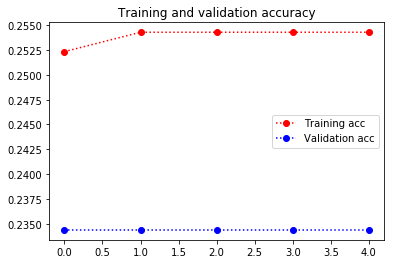

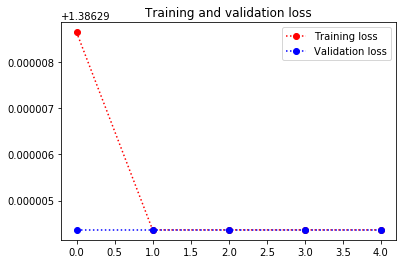

In [4]:
#np.random.seed(3)
#加载数据
IMAGE_SIZE = 227
DATA_DIR = r"G:\科研\多网络对比测试\model-test"
train_data, train_labels, test_data, test_labels = loadData(IMAGE_SIZE)
#输出训练和测试数据量
# print ("Train data size: ", len(train_data))
# print ("Test data size: ", len(test_data))

train_data=train_data.astype(np.float16)/255
test_data=test_data.astype(np.float16)/255
#将标签量进行转化
train_labels=np_utils.to_categorical(train_labels)
test_labels=np_utils.to_categorical(test_labels)
#设置检查点
# filepath=r"G:\科研\数据集\opendata_VRID\model\weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]
#设置最佳检查点
filepath=r"G:\科研\数据集\opendata_VRID\weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
#设置模型
num_classes=4
model=SqueezeNet(num_classes)
#编译模型
epochs = 5
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.9
sgd = SGD(lr=learning_rate, momentum=momentum,  decay=decay_rate, nesterov=False)
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

#匹配模型
#lrate = LearningRateScheduler(step_decay)
#callbacks_list = [lrate]
history=model.fit(train_data, train_labels,validation_split=0.2, nb_epoch=epochs,batch_size=8,callbacks=callbacks_list)
#测试模型
preds = np.argmax(model.predict(test_data), axis=1)
test_labels = np.argmax(test_labels, axis=1)
print (accuracy_score(test_labels, preds))
#保存模型
#model.save('squeeze-model(10,64).model')
#记录模型日志
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
#画模型准确率曲线和损失率曲线
plt.plot(epochs, acc, 'ro:', label='Training acc')
plt.plot(epochs, val_acc, 'bo:', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro:', label='Training loss')
plt.plot(epochs, val_loss, 'bo:', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
plt.savefig('graph.png')